In [213]:
import pandas as pd

In [214]:
# Provide the path to your CSV file
csv_file_path_encodeddf = '../data/encoded.csv'
csv_file_path_filtereddf = '../data/filtered_df.csv'


# Read the CSV file and create a DataFrame
encoded_df = pd.read_csv(csv_file_path_encodeddf)
filtered_df = pd.read_csv(csv_file_path_filtereddf)

In [215]:
encoded_df.head(10)

,GCS,T0Azotemiainmgdl,T0ALTinUL
0,1,1,0
1,1,1,0
2,1,1,1
3,1,1,0
4,1,1,0
5,1,0,0
6,1,1,1
7,1,1,1
8,1,1,0
9,1,1,0


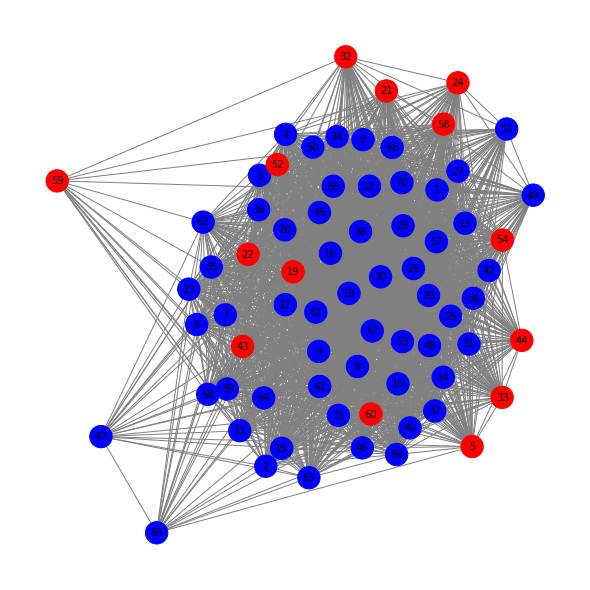

In [216]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your dataset is stored in a DataFrame called 'df'
# Assuming the filtered dataset with the "ICU" feature is stored in a DataFrame called 'filtered_df'
# Assuming the correlations are stored in a dictionary called 'correlations_dict'

# Compute weighted distance between two samples in the DataFrame
def compute_distance(df, index1, index2):
    sample1 = df.iloc[index1].values
    sample2 = df.iloc[index2].values
    weighted_distance = 0
    
    for i in range(len(sample1)):
        weighted_distance += abs(sample1[i] - sample2[i])
    
    return weighted_distance

# Step 1: Find pairwise weighted distances
dist_matrix = np.zeros((encoded_df.shape[0], encoded_df.shape[0]))

for i in range(encoded_df.shape[0]):
    for j in range(i + 1, encoded_df.shape[0]):
        weighted_dist = compute_distance(encoded_df, i, j)
        dist_matrix[i, j] = weighted_dist
        dist_matrix[j, i] = weighted_dist

# Check distances set to 0 outside diagonal
# for i in range(dist_matrix.shape[0]):
#     for j in range(dist_matrix.shape[1]):
#         if i != j and dist_matrix[i, j] == 0:
#             print(f"Distance between points {i} and {j} is set to 0.")


# Step 2: Find k nearest neighbors for each sample
k = 1  # Number of nearest neighbors
n_neighbors = []

for i in range(dist_matrix.shape[0]):
    neighbors = np.argsort(dist_matrix[i])
    
    # Find neighbors with distance equal to 0
    zero_distance_neighbors = [neighbor for neighbor in neighbors if dist_matrix[i, neighbor] == 0]
    
    # Find additional nearest neighbors with distance > 0
    additional_neighbors = [neighbor for neighbor in neighbors if dist_matrix[i, neighbor] ==1]
    
    neighbors_list = zero_distance_neighbors + additional_neighbors
    n_neighbors.append(neighbors_list)

# nearest_neighbors = np.argsort(dist_matrix, axis=1)[:, 1:(k+1)]

# # Find self-edges and replace them with the next closest neighbors
# for i in range(encoded_df.shape[0]):
#     if i in nearest_neighbors[i]:
#         self_edge_idx = np.where(nearest_neighbors[i] == i)[0][0]
#         nearest_neighbors[i][self_edge_idx] = np.argsort(dist_matrix, axis=1)[i][0]

# print(nearest_neighbors)

# Step 3: Create graph and add edges
graph = nx.Graph()
for i, neighbors in enumerate(n_neighbors):
    for neighbor in neighbors:
        if (i != neighbor) :
            graph.add_edge(i, neighbor)

# Step 4: Add nodes with color based on 'ICU' feature
for i in range(filtered_df.shape[0]):
    icu_value = filtered_df.iloc[i]['ICU']
    color = 'red' if icu_value == 1 else 'blue'
    graph.add_node(i, color=color)

# Step 5: Plot the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(graph)
node_colors = [graph.nodes[node]['color'] for node in graph.nodes]
nx.draw(graph, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=10, edge_color='gray')
plt.axis("off")
plt.show()


In [217]:
# Assuming your matrix is stored in a NumPy array called 'matrix'
unique_values = np.unique(dist_matrix)
print("Unique values in the matrix:")
print(unique_values)

Unique values in the matrix:
[0. 1. 2. 3.]


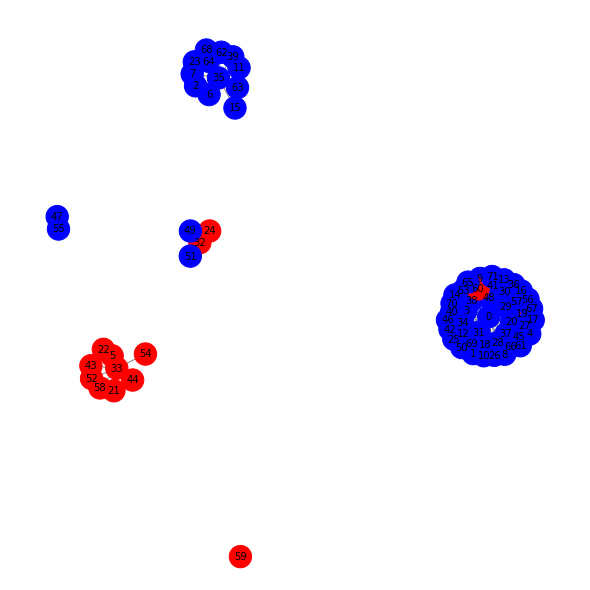

In [218]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Assuming your dataset is stored in a DataFrame called 'df'
# Assuming the filtered dataset with the "ICU" feature is stored in a DataFrame called 'filtered_df'
# Assuming the correlations are stored in a dictionary called 'correlations_dict'

# Compute weighted distance between two samples in the DataFrame
def compute_distance(df, index1, index2):
    sample1 = df.iloc[index1].values
    sample2 = df.iloc[index2].values
    weighted_distance = 0

    for i in range(len(sample1)):
        weighted_distance += abs(sample1[i] - sample2[i])

    return weighted_distance

# Step 1: Find pairwise weighted distances
dist_matrix = np.zeros((encoded_df.shape[0], encoded_df.shape[0]))

for i in range(encoded_df.shape[0]):
    for j in range(i + 1, encoded_df.shape[0]):
        weighted_dist = compute_distance(encoded_df, i, j)
        dist_matrix[i, j] = weighted_dist
        dist_matrix[j, i] = weighted_dist

# Step 2: Adjust distance values as per requirements
for i in range(dist_matrix.shape[0]):
    for j in range(dist_matrix.shape[1]):
        if i != j:
            if dist_matrix[i, j] == 0:
                dist_matrix[i, j] = 0  # Keep distance as 0
            elif dist_matrix[i, j] == 1:
                dist_matrix[i, j] = 100  # Set distance as 100
            else:
                dist_matrix[i, j] = np.inf  # Remove edge

# Step 3: Find k nearest neighbors for each sample
k = 1  # Number of nearest neighbors
n_neighbors = []

for i in range(dist_matrix.shape[0]):
    neighbors = np.argsort(dist_matrix[i])
    
    # Find neighbors excluding infinity distances
    valid_neighbors = [neighbor for neighbor in neighbors if dist_matrix[i, neighbor] != np.inf]
    neighbors_list = valid_neighbors[:k]  # Select k nearest neighbors
    
    n_neighbors.append(neighbors_list)

# Step 4: Create graph and add edges
graph = nx.Graph()
for i, neighbors in enumerate(n_neighbors):
    for neighbor in neighbors:
        if i != neighbor:
            graph.add_edge(i, neighbor)

# Step 5: Add nodes with color based on 'ICU' feature
for i in range(filtered_df.shape[0]):
    icu_value = filtered_df.iloc[i]['ICU']
    color = 'red' if icu_value == 1 else 'blue'
    graph.add_node(i, color=color)

# Step 6: Plot the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(graph)
node_colors = [graph.nodes[node]['color'] for node in graph.nodes]
nx.draw(graph, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=10, edge_color='gray')
plt.axis("off")
plt.show()


In [219]:
# Assuming your matrix is stored in a NumPy array called 'matrix'
unique_values = np.unique(dist_matrix)
print("Unique values in the matrix:")
print(unique_values)

Unique values in the matrix:
[  0. 100.  inf]


In [220]:
import csv

def find_combinations(dataframe):
    combinations = {}

    for index, row in dataframe.iterrows():
        criteria = tuple(row.values)
        sample = index

        if criteria not in combinations:
            combinations[criteria] = []

        combinations[criteria].append(sample)

    return combinations


print(encoded_df.head(10))

# Call the function to find the combinations
result = find_combinations(encoded_df)

# Print the combinations and associated samples
for criteria, samples in result.items():
    print(f'Criteria: {criteria} | Samples: {samples}')


   GCS  T0Azotemiainmgdl  T0ALTinUL
0    1                 1          0
1    1                 1          0
2    1                 1          1
3    1                 1          0
4    1                 1          0
5    1                 0          0
6    1                 1          1
7    1                 1          1
8    1                 1          0
9    1                 1          0
Criteria: (1, 1, 0) | Samples: [0, 1, 3, 4, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 20, 25, 26, 27, 28, 29, 30, 31, 34, 36, 37, 38, 40, 41, 42, 45, 46, 48, 50, 53, 56, 57, 60, 61, 65, 66, 67, 69, 70, 71]
Criteria: (1, 1, 1) | Samples: [2, 6, 7, 11, 15, 23, 35, 39, 62, 63, 64, 68]
Criteria: (1, 0, 0) | Samples: [5, 21, 22, 33, 43, 44, 52, 54, 58]
Criteria: (0, 1, 0) | Samples: [24, 32, 49, 51]
Criteria: (1, 0, 1) | Samples: [47, 55]
Criteria: (0, 1, 1) | Samples: [59]


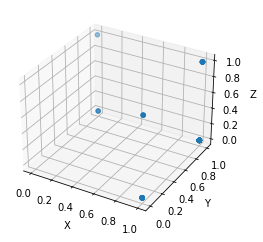

In [221]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming your DataFrame is called 'df' with columns 'x', 'y', and 'z'

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points in 3D
ax.scatter(encoded_df['GCS'], encoded_df['T0Azotemiainmgdl'], encoded_df['T0ALTinUL'])

# Set labels for each axis
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the 3D graph
plt.show()


In [222]:
import csv

def find_combinations(dataframe):
    combinations = {}

    for index, row in dataframe.iterrows():
        criteria = tuple(row.values)
        sample = index

        if criteria not in combinations:
            combinations[criteria] = []

        combinations[criteria].append(sample)

    return combinations


print(encoded_df.head(10))

# Call the function to find the combinations
result = find_combinations(encoded_df)

mapList = []

# Print the combinations and associated samples
for criteria, samples in result.items():
    newArray = [criteria]
    print(f'Criteria: {criteria} | Samples: {samples}')

    # Assuming you have a list of indices called 'samples' and a DataFrame called 'filtered_df' with the "ICU" feature

    # Initialize the counters
    count_1 = 0
    count_0 = 0

    # Iterate over the indices in the "samples" list
    for index in samples:
        # Access the row in the DataFrame using the index
        row = filtered_df.loc[index]
        
        # Check the value of the "ICU" feature
        icu_value = row['ICU']
        
        # Increment the respective counter
        if icu_value == 1:
            count_1 += 1
        elif icu_value == 0:
            count_0 += 1

    newArray.append([count_0])
    newArray.append([count_1])

    mapList.append(newArray)

print(mapList)


   GCS  T0Azotemiainmgdl  T0ALTinUL
0    1                 1          0
1    1                 1          0
2    1                 1          1
3    1                 1          0
4    1                 1          0
5    1                 0          0
6    1                 1          1
7    1                 1          1
8    1                 1          0
9    1                 1          0
Criteria: (1, 1, 0) | Samples: [0, 1, 3, 4, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 20, 25, 26, 27, 28, 29, 30, 31, 34, 36, 37, 38, 40, 41, 42, 45, 46, 48, 50, 53, 56, 57, 60, 61, 65, 66, 67, 69, 70, 71]
Criteria: (1, 1, 1) | Samples: [2, 6, 7, 11, 15, 23, 35, 39, 62, 63, 64, 68]
Criteria: (1, 0, 0) | Samples: [5, 21, 22, 33, 43, 44, 52, 54, 58]
Criteria: (0, 1, 0) | Samples: [24, 32, 49, 51]
Criteria: (1, 0, 1) | Samples: [47, 55]
Criteria: (0, 1, 1) | Samples: [59]
[[(1, 1, 0), [42], [2]], [(1, 1, 1), [12], [0]], [(1, 0, 0), [0], [9]], [(0, 1, 0), [2], [2]], [(1, 0, 1), [2], [0]], [(0, 1, 1), [0],

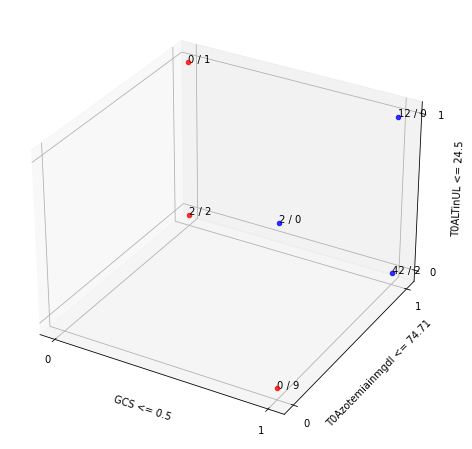

In [223]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming your array is called 'mapList'

# Create a larger 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract the coordinates and annotations from the 'mapList'
coordinates = [item[0] for item in mapList]
annotations = [f"{item[1][0]} / {item[2][0]}" for item in mapList]

# Extract the x, y, and z coordinates separately
x = [coord[0] for coord in coordinates]
y = [coord[1] for coord in coordinates]
z = [coord[2] for coord in coordinates]

# Plot the points in 3D with color mapping
for i in range(len(x)):
    item = mapList[i]  # Fetch the item
    color = 'red' if item[2][0] >= item[1][0] else 'blue'
    ax.scatter(x[i], y[i], z[i], c=color, marker='o', alpha=0.8)

# Add annotations next to the points
for i, annotation in enumerate(annotations):
    ax.text(x[i], y[i], z[i], annotation)

# Set scale of axes to 0 and 1
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_zticks([0, 1])

# Set labels for each axis
ax.set_xlabel('GCS <= 0.5')
ax.set_ylabel('T0Azotemiainmgdl <= 74.71')
ax.set_zlabel('T0ALTinUL <= 24.5')

# Show the 3D graph
plt.show()
